<a href="https://colab.research.google.com/github/aulphin/Target-Attack/blob/main/RISE_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rise_Target_Succesful

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from skimage.transform import resize


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.model = ResNet50(weights='imagenet')  # Load pretrained
        self.input_size = (224, 224)

    def call(self, x, training=False):
        return self.model(x, training=training)

    def run_on_batch(self, x):
        return self.model(x, training=False)


In [ ]:
model = Model()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = preprocess_input(x)
    return img, x

model = Model()

# Source image (to be attacked)
img_path = '/content/drive/MyDrive/Target-Attack_(XAI)/data/000029.jpg'
img, x = load_img(img_path)

# Target image (for explanation transfer)
target_img_path = '/content/drive/MyDrive/Target-Attack_(XAI)/data/tiger_cat.jpeg'
img_target, x_target = load_img(target_img_path)

# Expand dims
x_expanded = np.expand_dims(x, axis=0)
x_target_expanded = np.expand_dims(x_target, axis=0)

In [ ]:
# Get predicted class for source
output_np = model.run_on_batch(x_expanded)
target_class = np.argmax(output_np, axis=1)[0]
print("Predicted class index:", target_class)

Predicted class index: 176


In [ ]:
# Get predicted class for target
output_np_f = model.run_on_batch(x_target_expanded)
target_class_f = np.argmax(output_np_f, axis=1)[0]
print("Predicted class index:", target_class_f)

Predicted class index: 285


In [ ]:
N = 256  # number of masks
s = 8     # grid size
p1 = 0.5  # probability of 1

def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size
    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))
    for i in tqdm(range(N), desc='Generating masks'):
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    return masks.reshape(-1, *model.input_size)

masks = generate_masks(N, s, p1)


Generating masks: 100%|██████████| 256/256 [00:00<00:00, 410.99it/s]


In [ ]:
def get_rise_saliency(model, x, masks):
    N = masks.shape[0]
    masked = np.empty((N, *x.shape))
    for i in range(N):
        masked[i] = x * masks[i, :, :, np.newaxis]

    preds = []
    for i in tqdm(range(0, N, 50), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+50, N)]))
    preds = np.concatenate(preds)

    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N
#    return sal
    return sal.astype(np.float32)



In [ ]:
sal = get_rise_saliency(model, x, masks)
#sal_target_class = sal_target[target_class]


Explaining: 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


In [ ]:
sal_target = get_rise_saliency(model, x_target, masks)
sal_target_class = sal_target[target_class_f]


Explaining: 100%|██████████| 6/6 [00:01<00:00,  3.93it/s]


Explaining: 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


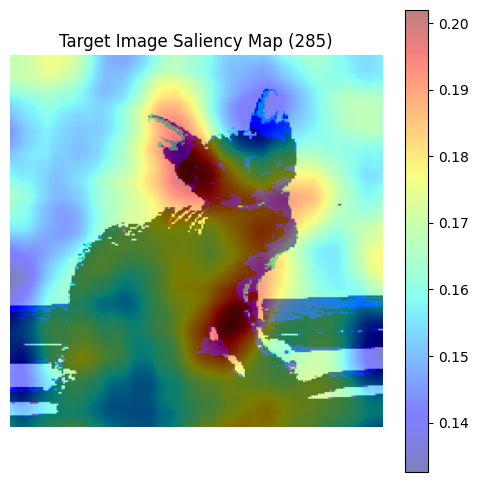

In [ ]:
# Compute the saliency map of the target image.
# Assume x_expanded is your original image with a batch dimension (shape: [1, 224, 224, 3])
sal_target = get_rise_saliency(model, x_target_expanded[0], masks)

# Extract the saliency map for the target class.
sal_target_class = sal_target[target_class_f]

# Display the original image overlaid with its saliency map.
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(x_target_expanded[0])

plt.imshow(sal_target_class, cmap='jet', alpha=0.5)
plt.title(f'Target Image Saliency Map ({target_class_f})')

plt.axis('off')
plt.colorbar()
plt.show()


Explaining: 100%|██████████| 6/6 [00:01<00:00,  3.87it/s]


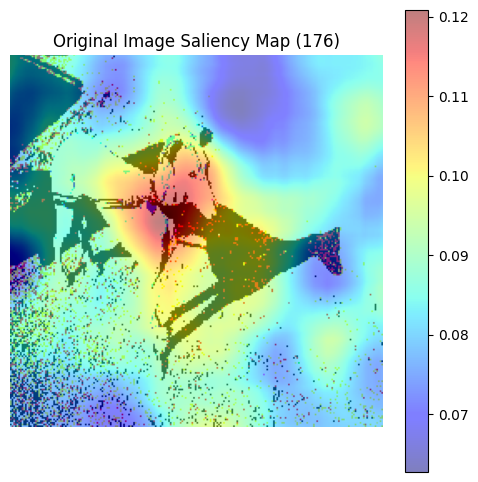

In [ ]:
# Compute the saliency map of the original image.
# Assume x_expanded is your original image with a batch dimension (shape: [1, 224, 224, 3])
sal_original = get_rise_saliency(model, x_expanded[0], masks)

# Extract the saliency map for the target class.
sal_original_class = sal_original[target_class]

# Display the original image overlaid with its saliency map.
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(x_expanded[0])
plt.imshow(sal_original_class, cmap='jet', alpha=0.5)

plt.title(f'Original Image Saliency Map ({target_class})')

plt.axis('off')
plt.colorbar()
plt.show()


RISE#################

In [ ]:
# Load your image x as (224, 224, 3)
#x_expanded = np.expand_dims(x, axis=0)   # Now shape is (1, 224, 224, 3)


In [ ]:
import tensorflow as tf
import numpy as np

def targeted_rise_attack(model, x_init, target_saliency, masks, target_class,
                         num_iter=30, alpha=1e7, beta=1e5, lr=1e-2):

    x_adv = tf.Variable(x_init, dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Convert target saliency for the target class to a float32 tensor
    target_sal = tf.convert_to_tensor(target_saliency[target_class], dtype=tf.float32)

    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)

            # Forward pass: get predictions for the adversarial image.
            # (Assuming your model is a subclassed tf.keras.Model so that it's callable.)
            #pred_adv = model(x_adv, training=False)
            with tf.device('/CPU:0'):
                 pred_adv = model(x_adv, training=False)


            # Get adversarial saliency map.
            # Note: x_adv has shape (1, 224, 224, 3); we pass x_adv[0] to remove the extra batch dim.
            with tf.device('/CPU:0'):
                 sal_adv = tf.numpy_function(lambda img: get_rise_saliency(model, img[0], masks), [x_adv], tf.float32)

            #al_adv = tf.numpy_function(lambda img: get_rise_saliency(model, img[0], masks),
                                         # [x_adv], tf.float32)
            # Reshape sal_adv to match the shape of target_saliency.
            sal_adv = tf.reshape(sal_adv, target_saliency.shape)   # e.g. (num_classes, 224, 224)
            sal_adv_class = sal_adv[target_class]

            # Compute the saliency loss: how different is the adversarial saliency from the target?
            loss_expl = tf.reduce_mean(tf.square(sal_adv_class - target_sal))

            # Compute the classification loss.
            # Here, we try to keep the adversarial prediction close to the original prediction.
            # Get the original prediction.
            original_pred = model(x_init, training=False)
            loss_class = tf.reduce_mean(tf.square(pred_adv[0][target_class] - original_pred[0][target_class]))

            # Combine losses.
            total_loss = alpha * loss_expl + beta * loss_class

        # Compute gradients and update adversarial image.
        grads = tape.gradient(total_loss, [x_adv])
        if grads[0] is not None:
            optimizer.apply_gradients(zip(grads, [x_adv]))

        # Clip the adversarial image to a valid range, e.g., [0, 1] if normalized.
        x_adv.assign(tf.clip_by_value(x_adv, 0.0, 1.0))

        if i % 5 == 0:
            print(f"[{i}] Total Loss: {total_loss.numpy():.4f} | Saliency Loss: {loss_expl.numpy():.4f} | Class Loss: {loss_class.numpy():.4f}")

    return x_adv


In [ ]:
# Run the targeted adversarial optimization
x_adv = targeted_rise_attack(model, x_expanded, sal_target, masks, target_class)


Explaining: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


[0] Total Loss: 75428.2656 | Saliency Loss: 0.0075 | Class Loss: 0.0000


Explaining: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


[5] Total Loss: 31580.3594 | Saliency Loss: 0.0000 | Class Loss: 0.3158


Explaining: 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


[10] Total Loss: 31576.2051 | Saliency Loss: 0.0000 | Class Loss: 0.3158


Explaining: 100%|██████████| 6/6 [00:08<00:00,  1.45s/it]


[15] Total Loss: 31571.3203 | Saliency Loss: 0.0000 | Class Loss: 0.3157


Explaining: 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


[20] Total Loss: 31564.8594 | Saliency Loss: 0.0000 | Class Loss: 0.3156


Explaining: 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


[25] Total Loss: 31556.3477 | Saliency Loss: 0.0000 | Class Loss: 0.3156


Explaining: 100%|██████████| 6/6 [00:06<00:00,  1.16s/it]


Explaining: 100%|██████████| 6/6 [00:01<00:00,  4.00it/s]


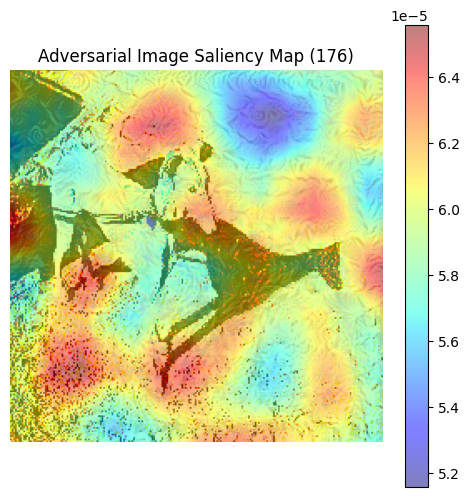

In [ ]:
# Compute the saliency map of the adversarial image.
# Note: x_adv is a batched tensor (shape: [1, 224, 224, 3]), so we pass x_adv[0] to get the image without the batch dim.
sal_x_adv = get_rise_saliency(model, x_adv[0], masks)

# Extract the saliency map for the target class.
sal_adv_class = sal_x_adv[target_class]

# Display the adversarial image overlaid with its saliency map.
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(x_adv[0])
plt.imshow(sal_adv_class, cmap='jet', alpha=0.5)
#plt.title('Adversarial Image Saliency Map (Target Class)')
plt.title(f'Adversarial Image Saliency Map ({target_class})')

plt.axis('off')
plt.colorbar()
plt.show()


"""
    Perform targeted attack on RISE explanations to match a target saliency.
    
    Parameters:
      model         : Your Keras model.
      x_init        : The initial input image, with batch dimension (1, 224, 224, 3).
      target_saliency: A NumPy array with the RISE saliency for each class, shape (num_classes, 224, 224).
      masks         : RISE masks (NumPy array).
      target_class  : The target class index.
      num_iter      : Number of iterations.
      alpha         : Weight for the explanation (saliency) loss.
      beta          : Weight for the classification loss.
      lr            : Learning rate for the optimizer.
      
    Returns:
      x_adv         : The adversarial image as a tf.Tensor.
    """

In [ ]:
import numpy as np

def gini(saliency):
    """
    Compute the Gini coefficient for a given saliency map.

    Parameters:
      saliency (np.array): A 2D NumPy array containing saliency values.

    Returns:
      float: The Gini coefficient.
    """
    # Flatten the saliency map to a 1D array.
    x = saliency.flatten().astype(np.float64)

    # Adjust for any negative values (if present) by shifting.
    if np.amin(x) < 0:
        x = x - np.amin(x)

    # Add a tiny constant to avoid division by zero.
    x += 1e-10

    # Sort the array in ascending order.
    x_sorted = np.sort(x)
    n = x_sorted.shape[0]
    index = np.arange(1, n + 1)

    # Compute Gini using the formula:
    # G = (2 * sum_i (i * x_sorted[i])) / (n * sum(x)) - (n + 1) / n
    gini_coeff = (2 * np.sum(index * x_sorted)) / (n * np.sum(x_sorted)) - (n + 1) / n
    return gini_coeff

# Assume sal_x_adv is the adversarial saliency map (2D array for target class),
# and sal_original is the original saliency map (2D array for target class).

# Example (replace these with your actual saliency maps):
# sal_x_adv = ... (computed adversarial saliency map for target class)
# sal_original = ... (computed original saliency map for target class)

# Compute Gini coefficients.
gini_adv = gini(sal_x_adv)
gini_orig = gini(sal_original)

print("Gini coefficient for adversarial saliency:", gini_adv)
print("Gini coefficient for original saliency:", gini_orig)

# You can also compute the difference to measure the adversarial impact.
impact = gini_adv - gini_orig
print("Adversarial impact (difference in Gini coefficients):", impact)


Gini coefficient for adversarial saliency: 0.7849593265846053
Gini coefficient for original saliency: 0.9441432623239587
Adversarial impact (difference in Gini coefficients): -0.1591839357393534
